<a href="https://colab.research.google.com/github/fercouri/Analise-de-Portico-Plano-pelo-MEF/blob/main/Trabalho_MEF_pr%C3%A1tica_computacional_(p%C3%B3rticos_planos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático 01: Análise de Pórtico Plano pelo MEF

## Dados

- Comprimento do Vão ($L$): 6,0 m
- Altura da Coluna Esquerda ($h_1$): 4,0 m
- Altura da Coluna Direita ($h_2$): 3,0 m
- Comprimento de Aplicação da Carga $q_1$ ($a$): 1,0 m
- Comprimento de Aplicação da Carga $q_2$ ($b$): 3,0 m
- Carga Distribuída Vertical ($q_1$): 10,0 kN/m (Para baixo)
- Carga Distribuída Horizontal ($q_2$): 10,0 kN/m (Para a esquerda)
- Carga Concentrada ($F$): 5,0 kN (Para a direita)

Propriedades do Material e Seção

- Módulo de Elasticidade ($E$): 200 GPa ($200 \times 10^9$ Pa)
- Raio da Seção ($r$): 3 cm (0,03 m)
- Área da Seção Transversal ($A$):$$A = \pi \cdot r^2 = \pi \cdot (0,03)^2 \approx 2,827 \times 10^{-3} \text{ m}^2$$
- Momento de Inércia ($I$):$$I = \frac{\pi \cdot r^4}{4} = \frac{\pi \cdot (0,03)^4}{4} \approx 6,362 \times 10^{-7} \text{ m}^4$$

## Implementação

--- Iniciando cálculo com fator de refinamento: 1 ---


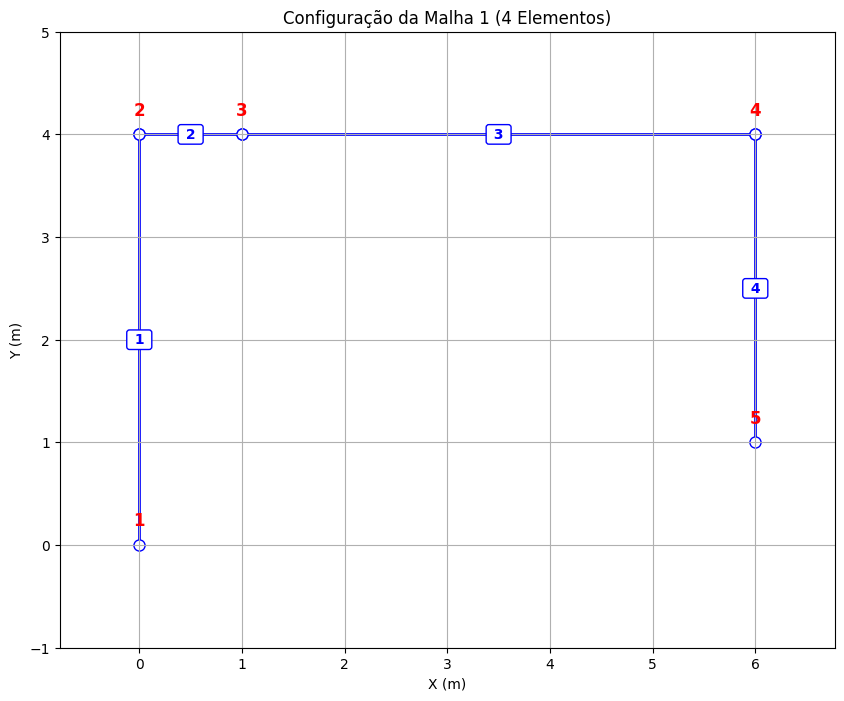

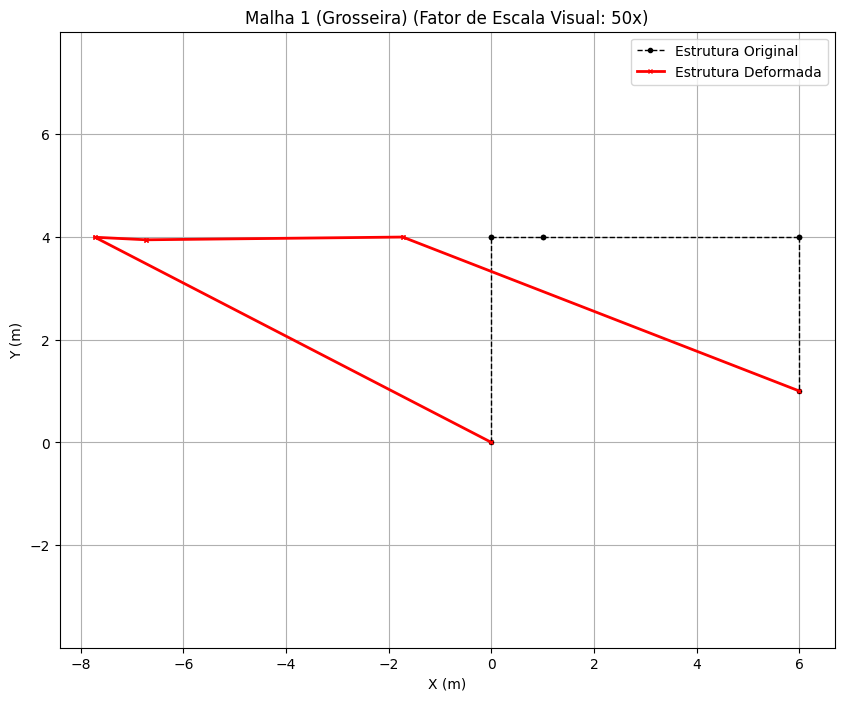



--- Iniciando cálculo com fator de refinamento: 2 ---


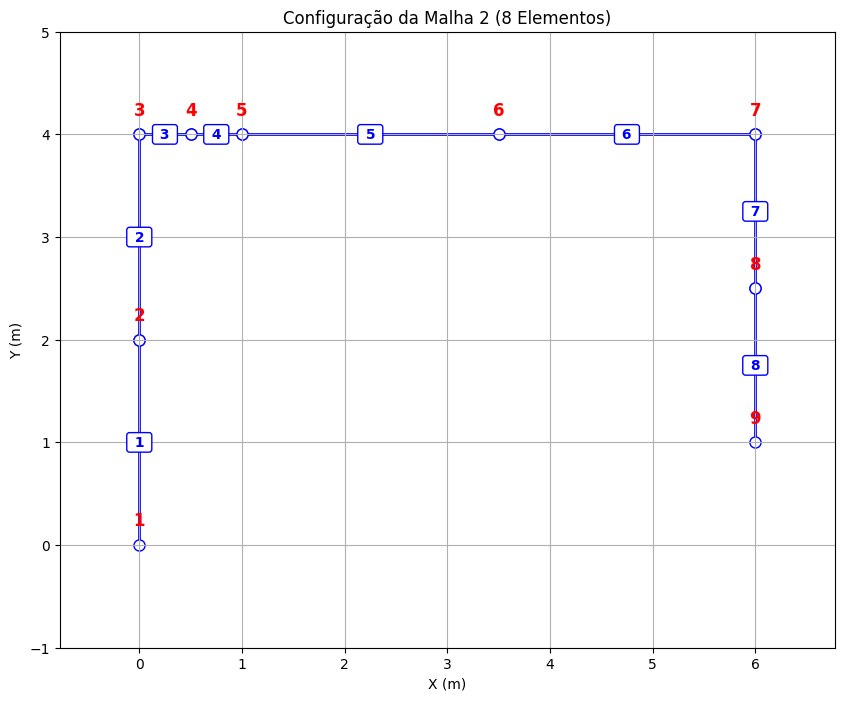

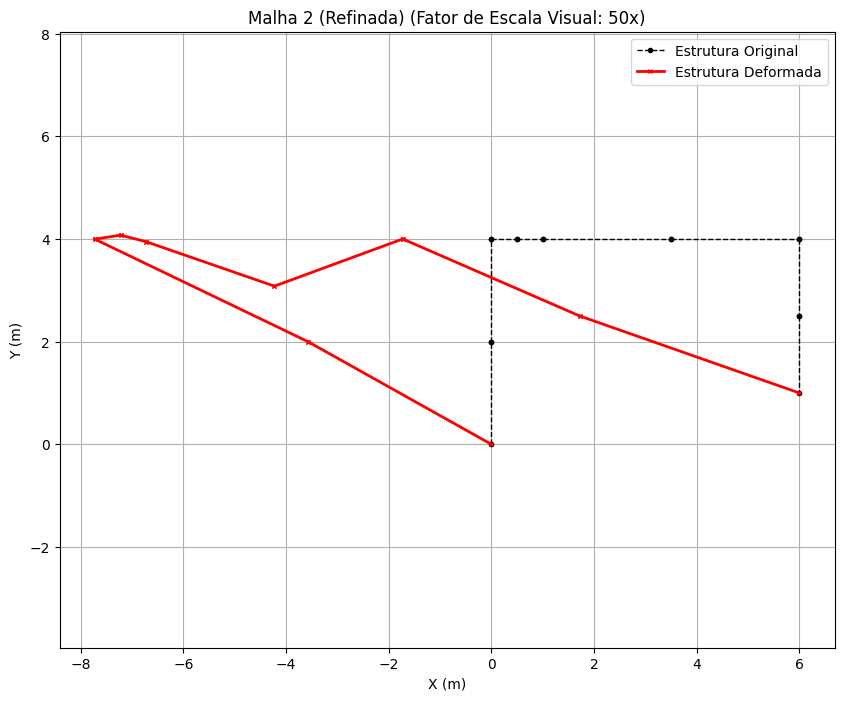


--- COMPARAÇÃO DE RESULTADOS (DESLOCAMENTO X NO TOPO ESQUERDO) ---
Malha 1 (4 elem): Ux = -154.4731 mm
Malha 2 (8 elem): Ux = -154.4731 mm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PROPRIEDADES FÍSICAS E GEOMÉTRICAS
E = 200e9       # 200 GPa em Pa
r = 0.03        # 3 cm em m
A = np.pi * r**2
I = (np.pi * r**4) / 4

# Parâmetros
F_conc = 5000.0     # Força concentrada (5 kN)
q1_dist = 10000.0   # Carga distribuída q1 (10 kN/m)
q2_dist = 10000.0   # Carga distribuída q2 (10 kN/m)
L_vão = 6.0
h_esq = 4.0
h_dir = 3.0
dist_a = 1.0
dist_b = 3.0

# FUNÇÕES DE ELEMENTOS FINITOS (Adaptação do MATLAB)

def rigidez_elemento(E, I, A, x1, y1, x2, y2):

    # Calcula a matriz de rigidez global de um elemento de pórtico
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    c = (x2 - x1) / L  # cosseno diretor
    s = (y2 - y1) / L  # seno diretor

    # Rigidez local (axial e flexão)
    k_axial = (E * A) / L
    k1 = (12 * E * I) / L**3
    k2 = (6 * E * I) / L**2
    k3 = (4 * E * I) / L
    k4 = (2 * E * I) / L

    # Matriz de Rigidez no Sistema Local
    k_local = np.array([
        [k_axial, 0, 0, -k_axial, 0, 0],
        [0, k1, k2, 0, -k1, k2],
        [0, k2, k3, 0, -k2, k4],
        [-k_axial, 0, 0, k_axial, 0, 0],
        [0, -k1, -k2, 0, k1, -k2],
        [0, k2, k4, 0, -k2, k3]
    ])

    # Matriz de Rotação
    R = np.array([
        [c, s, 0, 0, 0, 0],
        [-s, c, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, c, s, 0],
        [0, 0, 0, -s, c, 0],
        [0, 0, 0, 0, 0, 1]
    ])

    # Rigidez Global: K = R_transposta * k_local * R
    k_global = R.T @ k_local @ R
    return k_global, L, c, s

def carga_equivalente(q_x, q_y, L, c, s):

    # Transformar carga global para sistema local
    q_axial = q_x * c + q_y * s
    q_trans = -q_x * s + q_y * c

    # Reações de engaste perfeito
    # Força Axial
    fa = q_axial * L / 2

    # Força Cortante e Momento Fletor
    fy = q_trans * L / 2
    m = q_trans * L**2 / 12

    # Vetor local {fx1, fy1, m1, fx2, fy2, m2}
    f_local = np.array([fa, fy, m, fa, fy, -m])

    # Rotacionar vetor de forças para o sistema global
    R = np.array([
        [c, s, 0, 0, 0, 0],
        [-s, c, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, c, s, 0],
        [0, 0, 0, -s, c, 0],
        [0, 0, 0, 0, 0, 1]
    ])

    f_global = R.T @ f_local
    return f_global

# RESOLVER

def resolver_portico(fator_refinamento):

    # fator_refinamento: 1 para malha grossa, 2 para malha refinada.

    print(f"--- Iniciando cálculo com fator de refinamento: {fator_refinamento} ---")

    # Keypoints  da geometria
    keypoints = [
        np.array([0.0, 0.0]), # Base Esquerda (Apoio)
        np.array([0.0, 4.0]), # Topo Esquerdo
        np.array([1.0, 4.0]), # Fim da carga q1
        np.array([6.0, 4.0]), # Topo Direito
        np.array([6.0, 1.0])  # Base Direita (Apoio) - h2=3m descendo de 4m
    ]

    # Gerar Malha
    nos = []
    elementos = []

    # Definir conectividade entre os keypoints
    segmentos = [(0,1), (1,2), (2,3), (3,4)]

    id_no_atual = 0
    nos.append(keypoints[0]) # Adiciona o primeiro nó manualmente

    for idx_inicio, idx_fim in segmentos:
        p1 = keypoints[idx_inicio]
        p2 = keypoints[idx_fim]

        # Número de elementos neste segmento baseado no refinamento
        num_elem_segmento = 1 * fator_refinamento

        # Distância entre nós intermediários
        dx = (p2[0] - p1[0]) / num_elem_segmento
        dy = (p2[1] - p1[1]) / num_elem_segmento

        for i in range(num_elem_segmento):
            novo_no = np.array([p1[0] + dx*(i+1), p1[1] + dy*(i+1)])
            nos.append(novo_no)
            elementos.append([id_no_atual, id_no_atual + 1])
            id_no_atual += 1

    nos = np.array(nos)
    elementos = np.array(elementos)

    num_nos = len(nos)
    num_graus_liberdade = num_nos * 3  # 3 GLs por nó (u, v, theta)

    # Inicializar Matrizes Globais
    K_global = np.zeros((num_graus_liberdade, num_graus_liberdade))
    F_global = np.zeros(num_graus_liberdade)

    # ASSEMBLY
    for el_idx, el_nos in enumerate(elementos):
        n1, n2 = el_nos
        x1, y1 = nos[n1]
        x2, y2 = nos[n2]

        # Calcular rigidez do elemento
        k_el, L_el, c, s = rigidez_elemento(E, I, A, x1, y1, x2, y2)

        # Índices dos graus de liberdade na matriz global
        gls = [3*n1, 3*n1+1, 3*n1+2, 3*n2, 3*n2+1, 3*n2+2]

        # Somar na matriz global
        for i in range(6):
            for j in range(6):
                K_global[gls[i], gls[j]] += k_el[i, j]

        # APLICAÇÃO DE CARGAS DISTRIBUÍDAS
        f_el = np.zeros(6)

        # Ponto médio do elemento para verificar onde aplicar a carga
        xm = (x1+x2)/2
        ym = (y1+y2)/2

        # Carga q1: Vertical para baixo no trecho a=1m (Viga superior esquerda)
        if 0 <= xm <= 1.0 and np.isclose(ym, 4.0):
            # q1 é aplicada em Y negativo
            f_el += carga_equivalente(0, -q1_dist, L_el, c, s)

        # Carga q2: Horizontal esquerda na coluna direita (trecho b=3m)
        if np.isclose(xm, 6.0) and 1.0 <= ym <= 4.0:
            # q2 é aplicada em X negativo
            f_el += carga_equivalente(-q2_dist, 0, L_el, c, s)

        # Somar forças equivalentes no vetor global
        for i in range(6):
            F_global[gls[i]] += f_el[i]

    # APLICAÇÃO DE CARGA CONCENTRADA
    # Força F=5kN no topo esquerdo (0, 4)
    for i, no in enumerate(nos):
        if np.isclose(no[0], 0) and np.isclose(no[1], 4):
            # Aplica força em X positivo (GL 3*i)
            F_global[3*i] += F_conc
            break

    # CONDIÇÕES DE CONTORNO (ENGASTES)
    gls_fixos = []

    # Identificar nós fixos (Base Esquerda e Base Direita)
    for i, no in enumerate(nos):
        # Base Esq (0,0) ou Base Dir (6,1)
        if (np.isclose(no[0], 0) and np.isclose(no[1], 0)) or \
           (np.isclose(no[0], 6) and np.isclose(no[1], 1)):
            # Fixar u, v e rotação
            gls_fixos.extend([3*i, 3*i+1, 3*i+2])

    # Método da Redução de Matriz
    gls_livres = [i for i in range(num_graus_liberdade) if i not in gls_fixos]

    K_reduzida = K_global[np.ix_(gls_livres, gls_livres)]
    F_reduzida = F_global[gls_livres]

    # Solução do sistema linear
    U_reduzido = np.linalg.solve(K_reduzida, F_reduzida)

    # Reconstruir vetor total de deslocamentos
    U_total = np.zeros(num_graus_liberdade)
    U_total[gls_livres] = U_reduzido

    return nos, elementos, U_total

# EXECUÇÃO E PLOTAGEM

# Resolver para Malha 1 (fator 1) e Malha 2 (fator 2)
def plotar_malha(nos, elementos, titulo="Configuração da Malha"):
    plt.figure(figsize=(10, 8))

    # Plotar Elementos
    for idx, el in enumerate(elementos):
        x = nos[el, 0]
        y = nos[el, 1]
        plt.plot(x, y, 'b-', linewidth=2, marker='o', markersize=8, markerfacecolor='w', zorder=1)

        # Etiqueta do Elemento
        xc = np.mean(x)
        yc = np.mean(y)
        plt.text(xc, yc, f' {idx+1} ', color='blue', fontweight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'), zorder=2)

    # Etiqueta dos Nós
    for idx, no in enumerate(nos):
        plt.text(no[0], no[1] + 0.15, f'{idx+1}', color='red', fontweight='bold', ha='center', va='bottom', fontsize=12, zorder=3)

    plt.title(titulo)
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.axis('equal')
    # Ajustar limites do gráfico para visualização
    plt.xlim(np.min(nos[:,0])-1, np.max(nos[:,0])+1)
    plt.ylim(np.min(nos[:,1])-1, np.max(nos[:,1])+1)
    plt.show()

def plotar_deformada(nos, elementos, U, escala=50, titulo="Deformada"):
    plt.figure(figsize=(10, 8))

    # Plotar Estrutura Original
    for i, el in enumerate(elementos):
        x = nos[el, 0]
        y = nos[el, 1]
        # Label inteligente para aparecer só uma vez na legenda
        lbl = 'Estrutura Original' if i == 0 else ""
        plt.plot(x, y, 'k--', linewidth=1, marker='o', markersize=3, label=lbl)

    # Calcular Posições Deformadas
    nos_deformados = nos.copy()
    for i in range(len(nos)):
        nos_deformados[i, 0] += U[3*i] * escala
        nos_deformados[i, 1] += U[3*i+1] * escala

    # Plotar Estrutura Deformada
    for i, el in enumerate(elementos):
        x = nos_deformados[el, 0]
        y = nos_deformados[el, 1]
        lbl = 'Estrutura Deformada' if i == 0 else ""
        plt.plot(x, y, 'r-', linewidth=2, marker='x', markersize=3, label=lbl)

    plt.title(f"{titulo} (Fator de Escala Visual: {escala}x)")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

# EXECUÇÃO PRINCIPAL

# MALHA 1
nos1, elem1, U1 = resolver_portico(fator_refinamento=1)
plotar_malha(nos1, elem1, titulo="Configuração da Malha 1 (4 Elementos)")
plotar_deformada(nos1, elem1, U1, escala=50, titulo="Malha 1 (Grosseira)")

# MALHA 2
print("\n")
nos2, elem2, U2 = resolver_portico(fator_refinamento=2)
plotar_malha(nos2, elem2, titulo="Configuração da Malha 2 (8 Elementos)")
plotar_deformada(nos2, elem2, U2, escala=50, titulo="Malha 2 (Refinada)")

# Comparação Numérica de Resultados
# Procurar índice do nó do Topo Esquerdo (0, 4) em ambas as malhas
idx1 = np.where((nos1[:,0]==0) & (nos1[:,1]==4))[0][0]
idx2 = np.where((nos2[:,0]==0) & (nos2[:,1]==4))[0][0]

print("\n--- COMPARAÇÃO DE RESULTADOS (DESLOCAMENTO X NO TOPO ESQUERDO) ---")
print(f"Malha 1 (4 elem): Ux = {U1[3*idx1]*1000:.4f} mm")
print(f"Malha 2 (8 elem): Ux = {U2[3*idx2]*1000:.4f} mm")

## Anastruct

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 14.5 MB/s eta 0:00:00


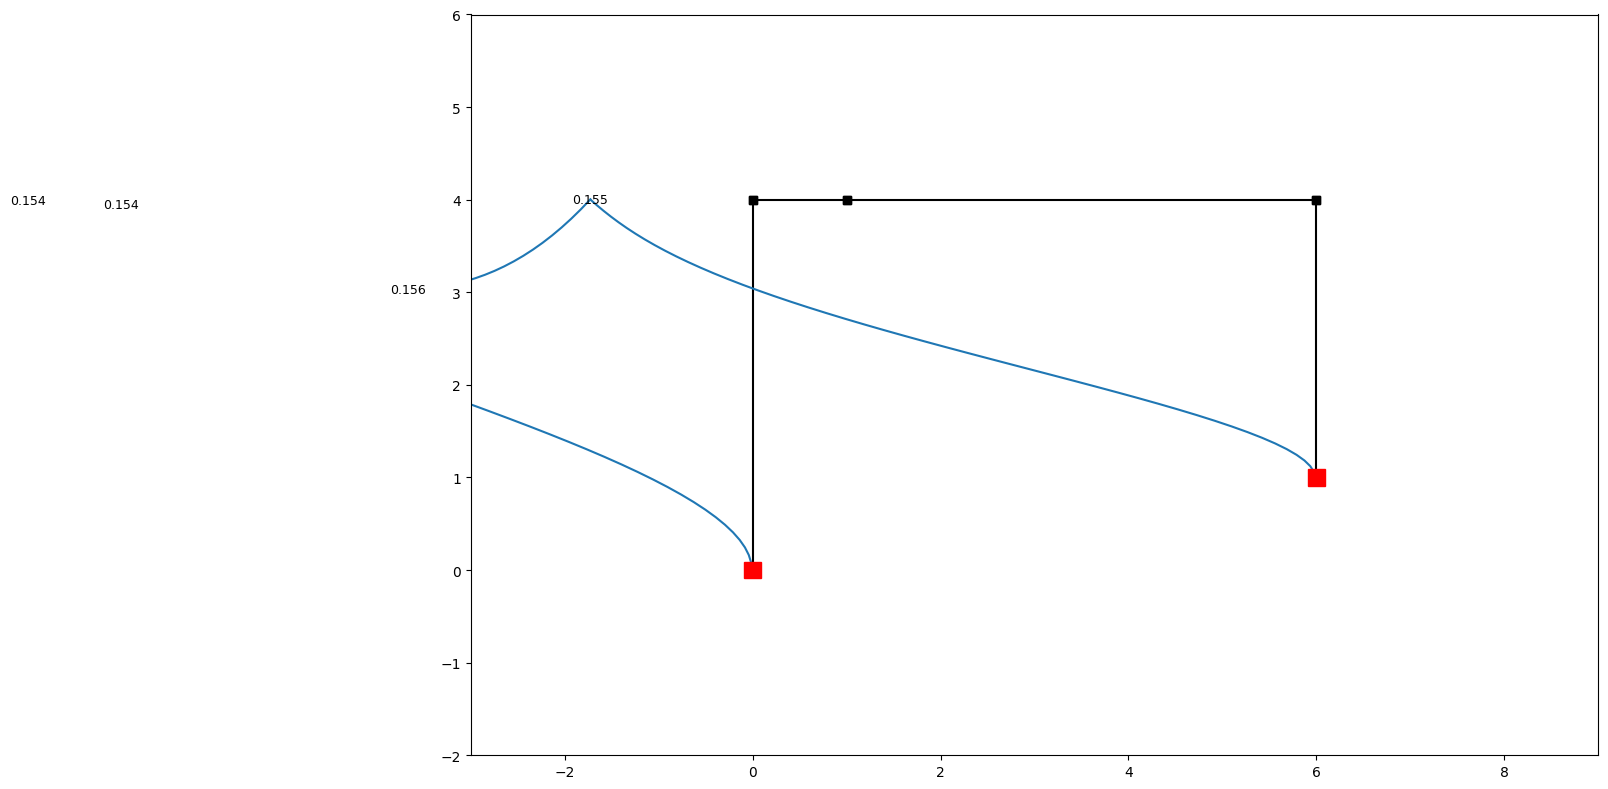

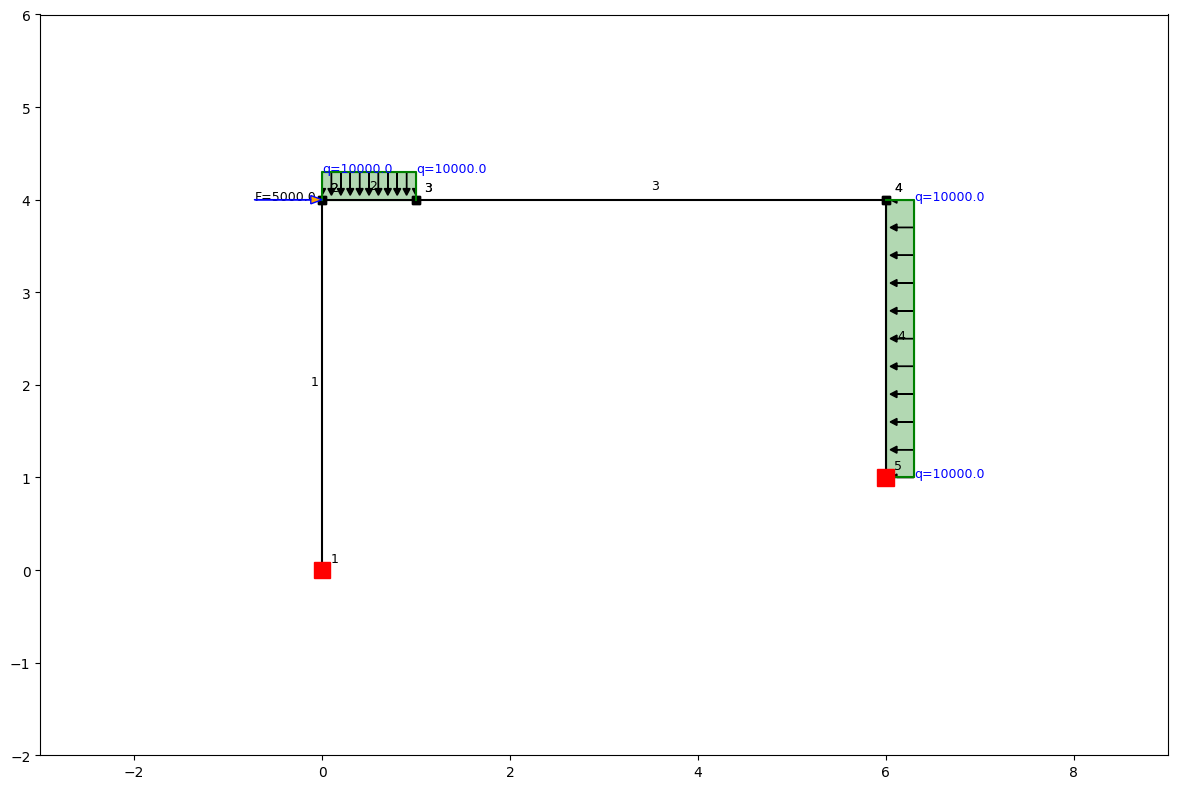

In [ ]:
!pip install --quiet anastruct
from anastruct import SystemElements
import numpy as np

# Dados
E = 200e9
r = 0.03
A = np.pi * r**2
I = (np.pi * r**4) / 4

ss = SystemElements(EA=E*A, EI=E*I)

# Malha 1 (4 Elementos)
# Nó 1(0,0), Nó 2(0,4), Nó 3(1,4), Nó 4(6,4), Nó 5(6,1)
ss.add_element(location=[[0, 0], [0, 4]]) # El 1
ss.add_element(location=[[0, 4], [1, 4]]) # El 2
ss.add_element(location=[[1, 4], [6, 4]]) # El 3
ss.add_element(location=[[6, 4], [6, 1]]) # El 4

# Apoios (Engastes nos nós 1 e 5)
ss.add_support_fixed(node_id=1)
ss.add_support_fixed(node_id=5)

# Cargas
# q1 na barra 2 (10kN/m = 10000 N/m)
ss.q_load(element_id=2, q=-10000)

# q2 na barra 4 (10kN/m para esquerda)
ss.q_load(element_id=4, q=-10000)

# Força pontual F=5kN no nó 2 (Topo esq)
ss.point_load(node_id=2, Fx=5000)

ss.solve()
ss.show_displacement(factor=50)
ss.show_structure()